In [44]:
# Modules classiques
import numpy as np
import pandas as pd

# Modules pour data-viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Options
pd.set_option("display.min_rows", 10)
pd.set_option("display.max_columns", 30)
pd.set_option("max_colwidth", 1000)

sns.set_style('darkgrid')
plt.rc('figure',figsize=(17,13))

# EDA
from wordcloud import *

# Preprocessing 
import re, string
from emoji import demojize

# Modélisation
from sklearn.feature_extraction.text import CountVectorizer

# Autres
from IPython.display import display
from PIL import Image

# Serialization
import pickle

# Distance text
from Levenshtein import distance

# Wordcloud
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
import cv2
from nltk.stem import WordNetLemmatizer

# Lemmatizer
import spacy
from spacy_lefff import LefffLemmatizer, POSTagger
from spacy.language import Language


from IPython.display import display
import dataframe_image as dfi

# Fonctions utiles

In [45]:
useful_col = ['id', 'date', 'content', 'user',
              'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
              'lang', 'sourceLabel', # lang pour filtrer ; sourceLabel pour stats
              'media', # Pour récupérer les photos
               # 'retweetedTweet', 
              'quotedTweet', 'inReplyToTweetId', # Savoir si c'est un retweet, une réponse, une quote...
              'mentionedUsers', # Pour repérer les comptes mentionnés le +
              'hashtags' # Pour voir la répartition 
              ]



def clean_dataset(df: pd.DataFrame, col_to_keep : list, since=None, until=None, debug=True):
    '''
    Cette fonction
    1. Conserve uniquement les colonnes utiles
    2. Restreint les tweets à un intervalle défini par [@since, @until]
    3. Supprime les tweets doublons, non français ou encore qui n'ont pas Kohlanta (sous forme de hashtag ou non) dans le contenu de leur tweet
    4. Extrait des informations essentielles 
    '''   
    
    if debug: 
        print('---------- Infos sur le dataset -----------')
        print(f'Taille initiale: {df.shape}')
    
    
    # 1. Conserve uniquement les colonnes utiles
    to_return = df[col_to_keep]
    
    # 2. Restreint les tweets à un intervalle défini par [@since, @until]
    to_return.date = to_return.date.apply(lambda x: x.astimezone('Europe/Paris'))
    tmp_shape = to_return.shape
    
    if since is not None:
        to_return = to_return[to_return.date >= since]
    if until is not None:
        to_return = to_return[to_return.date <= until]
        
    if debug: print(f'{tmp_shape[0] - to_return.shape[0]} tweets ne faisant pas partie de l\'intervalle de temps étudié supprimés.')
        
    # 3. Supprime les tweets doublons
    tmp_shape = to_return.shape
    to_return.drop(index=to_return[to_return.content.duplicated()].index, inplace=True)
    if debug: print(f'{tmp_shape[0] - to_return.shape[0]} duplicats supprimés.')
    
    # 3. Supprime les tweets non français
    tmp_shape = to_return.shape
    to_return.drop(index=to_return[to_return.lang != 'fr'].index, inplace = True)
    to_return.drop(labels='lang', axis='columns', inplace=True)
    
    if debug: print(f'{tmp_shape[0] - to_return.shape[0]} tweets non français supprimés.')
    
    # 3. Certains tweets ne parlent pas de Koh-Lanta mais mentionne quelqu'un qui possède cela dans son username
    tmp_shape = to_return.shape
    tweets_without_kohlanta_content = to_return[~(to_return.content.str.contains('Koh Lanta', case=False) | \
                                    to_return.content.str.contains('KohLanta', case=False) | \
                                    to_return.content.str.contains('Koh-Lanta', case=False) | \
                                    to_return.content.str.contains('Koh- Lanta', case=False) | \
                                    to_return.content.str.contains('Koh -Lanta', case=False))]

    to_return.drop(index=tweets_without_kohlanta_content.index, inplace=True)
    if debug: print(f'{tmp_shape[0] - to_return.shape[0]} tweets avec des usernames incorrects supprimés')
    
    # 4. Extrait des infos essentielles
    # Récupération de l'username
    user_name = to_return.user.apply(func = lambda x: x['username'])
    
    to_return.drop('user', axis='columns', inplace=True)
    to_return['user_name'] = user_name
    
    # Récupération des comptes mentionnés
    def users_mentioned(list_users):
        usernames = []
        for ind_user in range(0, len(list_users)):
            usernames.append(list_users[ind_user]['username'])
        return usernames
        
    tmp = to_return.mentionedUsers.fillna(value=np.nan)
    list_mentioned_users = tmp.apply(lambda x: users_mentioned(x) if type(x) == list else np.nan)
    
    to_return.drop('mentionedUsers', axis='columns', inplace=True)
    to_return['mentioned_users'] = list_mentioned_users
    
    # Le tweet est-il une réponse ?
    isReply = to_return.inReplyToTweetId.apply(lambda x: False if np.isnan(x) else True)
    
    to_return.drop('inReplyToTweetId', axis='columns', inplace=True)
    to_return['isReply'] = isReply
    
    # Le tweet est-il une quote ?
    isQuote = to_return.quotedTweet.apply(lambda x: False if x is None else True)
    
    to_return.drop('quotedTweet', axis='columns', inplace=True)
    to_return['isQuote'] = isQuote
    
    # Extraction de l'URL de la photo s'il en contient une
    def get_img_media_tweets(content):
        if not (content is None): # On vérifie que l'objet n'est pas nul avant d'accéder à son contenu
            if content[0]['_type'] == 'snscrape.modules.twitter.Photo':
                return content[0]['fullUrl']

        return np.nan # Si objet nul ou pas une photo
    
    urlImg = to_return.media.apply(get_img_media_tweets)
    
    to_return.drop('media', axis='columns', inplace=True)
    to_return['urlImg'] = urlImg 
    
    
    if debug:
        print('')
        print(f'Premier tweet: {to_return.date.min()}')
        print(f'Dernier tweet: {to_return.date.max()}')
        print(f'{isReply.sum()} tweets sont des réponses')
        print(f'{isQuote.sum()} tweets sont des quotes')
        print(f'{urlImg.notna().sum()} tweets contiennent des images')
        print('')
        print(f'{df.shape[0]-to_return.shape[0]} lignes supprimées au total')
        print(f'{df.shape[1]-to_return.shape[1]} colonnes supprimées au total')
        print(f'Nouvelle taille: {to_return.shape}')
        print('\n')
    
    return to_return.reset_index(drop=True)

In [3]:
compte_candidats = {
  '@TeheiuraTEAHUI':'teheuira',
  '@Laurentmaistret':'laurent',
  '@NamadiaKohlanta':'namadia',
  '@Blz_Freddy':'freddy',
  '@candicekohlanta':'candice',
  '@alixkohlanta':'alix',
  '@AlexandraKoh':'alexandra',
  '@loickohlanta':'loic',
  '@claude_KohLanta':'claude',
  '@karimakohlanta':'karima',
  '@Coumba_kohLanta':'coumba',
  '@MaximeKohLanta':'maxime',
  '@clemencecastel1':'clemence',
  '@jadekl7':'jade',
  '@DenisBrogniart':'denis',
}

def nlp_pipeline(text):
    '''
    Cette pipeline nettoie nos tweets, on part du moins restrictif (suppression de combinaison particulière) au plus restrictif 
    La pipeline suivie est la suivante:
    0. Remplace les noms des comptes candidats par leur prénom
    1. Passe l'ensemble du texte en minuscule
    2. Remplace les line feed et carriage return par des espaces
    3. Supprime les URLs
    4. Supprime les mentions
    5. Supprime tous les hashtags comment par #koh (insensible à la casse)
    6. Remplace les émoticons par leurs émotions correspondantes
    7. Supprime la ponctuation et les nombres
    
    '''

    for compte, nom in compte_candidats.items():
        text = text.replace(compte, nom)

    text = text.lower() # Passe l'ensemble du texte en minuscule
    text = text.replace('\n', ' ').replace('\r', '') # Remplace les line feed et carriage return par des espaces 
    text = re.sub(r'www\.\S+|https?\S+', '', text) # Supprime les URLs http ou https ou juste www.
    text = re.sub(r'@\S+', '', text) # Supprime les mentions ( Elles peuvent contenir le nom d'un twittos qui est le même que celui d'un candidat !)

    # text = re.sub(r'@\S+', '', text) # Supprime les mentions
    
    text = re.sub(r'#koh\S+', 'koh lanta', text, flags=re.IGNORECASE) # Supprime tous les hashtags commençant par #koh (insensible à la casse)
    text = text.replace('#', '') # Supprime les #
     
    text = demojize(text, language='fr') # Traite les emojis
#     text = text.replace('_', ' ')

    text = text.replace('é','e').replace('è', 'e').replace('ê', 'e').replace('ï','i') # Supprime les accents
    
#     for p in string.punctuation: # Supprime la ponctuation // text = re.sub(r'[!"#\$%&\'\(\)\*\+,-\.\/:;<=>\?@\[\\\]\^_`{\|}~]', '', text)
#         text = text.replace(p, '')
#     text = re.sub(r'[0-9]', '', text) # Supprime les nombres  

    return text

# Récupération et traitement des données brutes

In [4]:
em0 = pd.read_json('./data/emission_0.json', lines=True)
em1 = pd.read_json('./data/emission_1.json', lines=True)
em2 = pd.read_json('./data/emission_2.json', lines=True)
em3 = pd.read_json('./data/emission_3.json', lines=True)
em4 = pd.read_json('./data/emission_4.json', lines=True)
em5 = pd.read_json('./data/emission_5.json', lines=True)
em6 = pd.read_json('./data/emission_6.json', lines=True)
em7 = pd.read_json('./data/emission_7.json', lines=True)
em8 = pd.read_json('./data/emission_8.json', lines=True)
em9 = pd.read_json('./data/emission_9.json', lines=True)
em10 = pd.read_json('./data/emission_10.json', lines=True)
em11 = pd.read_json('./data/emission_11.json', lines=True)
em12 = pd.read_json('./data/emission_12.json', lines=True)
em13 = pd.read_json('./data/emission_13.json', lines=True)
em14 = pd.read_json('./data/emission_14.json', lines=True)

In [41]:
pd.set_option("max_colwidth", 20)
pd.options.display.width = 200
dfi.export(em0[['_type', 'url', 'date', 'user', 'content', 'conversationId', 'sourceUrl']].head(1), 
           'em0.png', table_conversion='matplotlib', fontsize=100, max_cols=10)

In [8]:
DEBUG = False

# Avant la première émission
until = pd.Timestamp('2021-08-24 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em0, em1], ignore_index=True)

df_em0 = clean_dataset(df=tmp, col_to_keep=useful_col, until=until, debug=DEBUG)

# Emission 1
since = pd.Timestamp('2021-08-24 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-08-31 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em1, em2], ignore_index=True)

df_em1 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 2
since = pd.Timestamp('2021-08-31 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-09-14 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em2, em3], ignore_index=True)

df_em2 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)


# Emission 3
since = pd.Timestamp('2021-09-14 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-09-21 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em3, em4], ignore_index=True)

df_em3 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since,until=until, debug=DEBUG)

# Emission 4
since = pd.Timestamp('2021-09-21 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-09-28 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em4, em5], ignore_index=True)

df_em4 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 5
since = pd.Timestamp('2021-09-28 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-10-05 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em5, em6], ignore_index=True)

df_em5 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 6
since = pd.Timestamp('2021-10-05 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-10-12 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em6, em7], ignore_index=True)

df_em6 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 6
since = pd.Timestamp('2021-10-12 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-10-19 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em7, em8], ignore_index=True)

df_em7 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 8
since = pd.Timestamp('2021-10-19 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-10-26 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em8, em9], ignore_index=True)

df_em8 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 9
since = pd.Timestamp('2021-10-26 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-11-02 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em9, em10], ignore_index=True)

df_em9 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 10
since = pd.Timestamp('2021-11-02 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-11-09 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em10, em11], ignore_index=True)

df_em10 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 11
since = pd.Timestamp('2021-11-09 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-11-23 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em11, em12], ignore_index=True)

df_em11 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 12
since = pd.Timestamp('2021-11-23 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-11-30 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em12, em13], ignore_index=True)

df_em12 = clean_dataset(df=tmp, col_to_keep=useful_col, until=until, debug=DEBUG)

# Emission 13
since = pd.Timestamp('2021-11-30 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-12-07 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em13, em14], ignore_index=True)

df_em13 = clean_dataset(df=tmp, col_to_keep=useful_col, until=until, debug=DEBUG)

# Emission 14
since = pd.Timestamp('2021-12-07 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-12-14 21:05:00', tz='Europe/Paris')
# tmp = pd.concat([em13, em14], ignore_index=True)

df_em14 = clean_dataset(df=em14, col_to_keep=useful_col, until=until, debug=DEBUG)


In [24]:
df_em0.head(1)

,id,date,content,replyCount,retweetCount,likeCount,quoteCount,sourceLabel,hashtags,user_name,mentioned_users,isReply,isQuote,urlImg
0,1429956386822176768,2021-08-24 01:59:04+02:00,"Koh Lanta pardon, saison h...",0,0,0,0,Twitter for iPhone,None,Namizo_ys,NaN,False,False,NaN


In [49]:
nom_candidats = ['Freddy', 'Teheuira', 'Patrick', 'Alexandra', 'Cindy', 'Claude', 'Karima', 'Jade', 'Maxime', 
                  'Laurent', 'Candice', 'Sam', 'Clementine', 'Ugo', 'Namadia', 'Christelle', 'Coumba', 'Loic', 
                  'Clemence', 'Phil', 'Alix', 'Denis']

In [50]:
dfs = [df_em0, df_em1, df_em2, df_em3, df_em4, df_em5, df_em6, df_em7, df_em8, df_em9, df_em10, df_em11, df_em12, df_em13, df_em14]

# Calcul de popularité "simple"

### NER (Détection des noms des candidats)

Ici, je repère l'ensemble des entités de personnes dans les tweets pour pouvoir déduire les appelations données à l'ensemble des candidats. <br>
Ensuite j'effectue une distance de similarité entre ces "appelations" et les noms réels des candidats. <br>
Cela me permet d'assigner l'ensemble des appelations à un candidat donné. <br>

Voir: https://www.baeldung.com/cs/string-similarity-edit-distance

In [186]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")

nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")

In [6]:
def trouve_surnoms(df:pd.DataFrame, nom_candidats: list):
       
    # Par batch de 512, récupère l'ensemble des entités "Personnes" trouvées dans le contenu des tweets
    persons = []
    start = 0
    for stop in range(0, df.shape[0], 512):
        output = nlp(' '.join(df.iloc[start:stop].content.values)) # Concatène 512 tweets en un seul string
        start = stop
        for entity in output:
            if entity['entity_group'] == 'PER':
                persons.append(entity['word']) # Ajoute l'entité reconnue à notre liste
      
    # On nettoie ici les noms/surnoms obtenus
    persons = list(map(lambda x: x.split(), persons)) # On éclate en un unique mots les entités contenant plusieurs mots (Ex: 'Claude le meilleur')
    clean = [] # clean est notre liste avec tous les surnoms trouvés écrits 'proprement'
    for nom in persons: # On passe notre liste en 1D
        if type(nom)==list:
            clean += nom
        else:
            clean.append(nom)
            
    clean = [nom for nom in clean if (len(nom) >= 3 and len(nom) < 13)] # On supprime les noms trop courts ou trop longs
    clean = np.unique(clean)
    
    # On calcule la distance de levenshtein entre les surnoms trouvés et les noms réels des candidats.
    # Pour ensuite classer dans un dict les trouvailles
    surnoms_trouves = {}
    for nom in nom_candidats:
        res = [] # res contient l'ensemble des distances noms - surnoms
        distance_max = round(len(nom)*0.33 - 1) # La distance de levenshtein maximum acceptée pour considérer cela comme une faute de frappe/Une autre appellation du candidat
        
        for entity in clean: # Calcul de la distance pour chaque entité trouvée
            res.append(distance(entity, nom.lower()))
        res = pd.Series(res)
        
        surnoms_trouves[nom] = clean[res[res <= distance_max].index] # Assigne les surnoms < à une certaine distance définie aux noms des candidats
        surnoms_trouves[nom] = np.append(surnoms_trouves[nom], nom.lower()) # Ajoute le nom du candidat à cette liste
        
        if nom == 'Teheuira':
            surnoms_trouves[nom] = np.append(surnoms_trouves[nom], 'tehe') # Exception pour teheuira où l'on connait un de ces surnoms populaire
        
        surnoms_trouves[nom] = np.unique(surnoms_trouves[nom]) # On supprime les doublons
                
    return surnoms_trouves

In [20]:
trouve_surnoms(df=df_em12, nom_candidats=nom_candidats)

{'Freddy': array(['freddy'], dtype='<U12'),
 'Teheuira': array(['Teheuira', 'Teheura', 'tehe', 'teheiura', 'teheuira'],
       dtype='<U12'),
 'Patrick': array(['patrick'], dtype='<U12'),
 'Alexandra': array(['Alexandra', 'alexandra'], dtype='<U12'),
 'Cindy': array(['cindy'], dtype='<U12'),
 'Claude': array(['Claude', 'claude'], dtype='<U12'),
 'Karima': array(['karima'], dtype='<U12'),
 'Jade': array(['jade'], dtype='<U12'),
 'Maxime': array(['maxime'], dtype='<U12'),
 'Laurent': array(['Laurent', 'laurent'], dtype='<U12'),
 'Candice': array(['candice'], dtype='<U12'),
 'Sam': array(['sam'], dtype='<U12'),
 'Clementine': array(['clementine'], dtype='<U12'),
 'Ugo': array(['ugo'], dtype='<U12'),
 'Namadia': array(['namadia'], dtype='<U12'),
 'Christelle': array(['Christelle', 'christelle'], dtype='<U12'),
 'Coumba': array(['Coumba', 'coumba'], dtype='<U12'),
 'Loic': array(['loic'], dtype='<U12'),
 'Clemence': array(['Clémence', 'clemence'], dtype='<U12'),
 'Phil': array(['phil'], dty

In [53]:
def save_all_surnames(until_em=14, dfs=dfs, nom_candidats=nom_candidats):
    for num in range(0, until_em+1):
        path_dict = f'./data_jugement/surnoms/surnoms_em{num}.pickle'
        df = dfs[num] # Récupère le dataset de l'émission
        df.content = df.content.apply(nlp_pipeline)
        
        d = trouve_surnoms(df=df, nom_candidats=nom_candidats)
        with open(path_dict, 'wb') as f:
            pickle.dump(d, f) # Sauvegarde l'ensemble des surnoms trouvés pour l'émission @num

In [ ]:
save_all_surnames(until_em=14, dfs=dfs, nom_candidats=nom_candidats)

In [52]:
def surnoms_trouves(nom, until_em = 14):
    '''
    Fonction permettant de trouver tous les surnoms trouvés pour un candidat
    '''
    result = []
    for ind in range(0,until_em+1):
        path = f'./data_jugement/surnoms/surnoms_em{ind}.pickle'
        d=pickle.load(open(path,'rb'))
        result.append(d[nom].tolist())
    return list(set(sum(result, []))), result

In [9]:
for nom in nom_candidats:
    all_results, result = surnoms_trouves(nom, 14)
    print(all_results)

['freddy']
['theura', 'tehueira', 'tehura', 'tehehura', 'teheuira', 'tehuira', 'heuira', 'teheura', 'teheiru', 'teiheura', 'tehe', 'teheiuira', 'tehoura', 'theheuira', 'tehiura', 'teheiura', 'theuira', 'teheirua']
['patrick', 'patrik']
['alexandra', 'lexandra']
['cindy']
['claud', 'claude']
['karima', 'karim']
['jade']
['maxim', 'maxime']
['laurant', 'laurent']
['candice']
['sam']
['clementine']
['ugo']
['amadia', 'namadia', 'namandia']
['christel', 'cristelle', 'christelle']
['cumba', 'comba', 'couba', 'coumva', 'coumba', 'koumba']
['loic']
['clemence', 'clement']
['phil']
['alix']
['dennis', 'donis', 'denis']


### Création de datasets par candidats

La cellule ci-dessous nous créé l'ensemble des datasets pour chaque candidats et pour chaque émission. <br>
Etapes: 
1. Nettoyage des tweets
2. Recherche des surnoms pour chaque candidat (Sauvegarde des surnoms trouvés dans un pickle dict)
3. Création du dataset du candidat en fonction des surnoms trouvés
4. Sauvegarde des datasets localement pour une réutilisation ultérieure !

In [54]:
def save_datasets_candidates(from_em=0, until_em=14, nom_candidats=nom_candidats):
    for num in range(from_em, until_em+1): # On parcourt les datasets
        for nom in nom_candidats: # On parcourt les candidats
            path_to_save = f'./data_jugement/em{num}/'
            path_dict = f'./data_jugement/surnoms/surnoms_em{num}.pickle'
            end_file = f'{nom.lower()}.csv'
            
            df = dfs[num] # Récupère le dataset de l'émission
            df.content = df.content.apply(nlp_pipeline)
            
            all_results, result = surnoms_trouves(nom, until_em) # Récupère tous les surnoms trouvés pour un candidat
            pattern = '|'.join(list(map(lambda x: '\\b'+x+'\\b', all_results))) # Pattern à respecter
            reg_pattern = re.compile(pattern)
            
            to_save = df[df.content.str.contains(reg_pattern, regex=True)] # Récupère tous les tweets mentionnant @nom
            to_save.to_csv(path_to_save + end_file) # Sauvegarde le nouveau dataset


In [268]:
%%time
save_datasets_candidates(0,14)

Wall time: 1h 10min


### Tous les tweets faits sur un candidat

In [55]:
def all_infos(nom, until_em=14):
    '''
    Récupère toutes les données pour un candidat précis
    '''
    results= pd.DataFrame()
    for num in range(0,15):
        path = f'./data_jugement/em{num}/'
        df = pd.read_csv(path + nom.lower() + '.csv')
        results = pd.concat([results, df])
    return results.drop_duplicates(subset='content', )

### Wordcloud

[Lemmatization Lefff](https://github.com/sammous/spacy-lefff])

In [79]:
@Language.factory('french_lemmatizer')
def create_french_lemmatizer(nlp, name):
    return LefffLemmatizer(after_melt=True, default=True)

@Language.factory('melt_tagger')  
def create_melt_tagger(nlp, name):
    return POSTagger()

nlp = spacy.load('fr_core_news_sm')
nlp.add_pipe('melt_tagger', after='parser')
nlp.add_pipe('french_lemmatizer', after='melt_tagger')

ValueError: [E004] Can't set up pipeline component: a factory for 'french_lemmatizer' already exists. Existing factory: <function create_french_lemmatizer at 0x000001DCF4311EE0>. New factory: <function create_french_lemmatizer at 0x000001DBC9468160>

In [74]:
def plot_wordcloud(nom_candidat, until_em, stop_words_fr, im_size=(2000,2000), random_state=0):
    w = all_infos(nom_candidat, until_em).reset_index()
    
    all_results, _ = surnoms_trouves(nom_candidat)
    stop_words_fr.update(all_results)
    
    w.content = w.content.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words_fr]))
    
    # Lemmatization
#     w.content = w.content.apply(nlp).apply(lambda x: " ".join([token.lemma_ for token in x])) # Ne fonctionne pas très bien
    
    # Donne plus de poids aux tweets avec beaucoup de retweets 
    def multiply_content(row):
        multiply = (min(round(row.retweetCount/100), 20)) # On multiplie le tweet max par 10 fois
        return (row.content+' ')*(multiply+1)
    
    w.content = w.apply(multiply_content, axis=1)    
    all_text = ' '.join(w.content)
    
    
    # WordCloud !
    img = cv2.imread('./wordcloud/Totem2.png')
    res = cv2.resize(img, dsize=im_size, interpolation=cv2.INTER_CUBIC)

    wc = WordCloud(stopwords=stop_words_fr, font_path='./wordcloud/Roboto-Black.ttf',
                   background_color="white", mask=res, contour_width=1,
                   max_font_size=256, min_word_length=3, max_words=2000, 
                   width=res.shape[1], height=res.shape[0],
                   random_state=random_state)
    
    wc.generate(all_text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
    return wc

def plot_wordcloud_cv(nom_candidat, until_em, stop_words_fr, im_size=(2000,2000), random_state=0):
    w = all_infos(nom_candidat, until_em).reset_index()
    
    all_results, _ = surnoms_trouves(nom_candidat)
    stop_words_fr.update(all_results)

    w.content = w.content.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words_fr]))

    def multiply_content(row):
        multiply = (min(round(row.retweetCount/100), 20)) # On multiplie le tweet max par 10 fois
        return (row.content+' ')*(multiply+1)

    # w.content = w.apply(multiply_content, axis=1)    
    all_text = ' '.join(w.content)

    vectorizer = CountVectorizer(min_df=50, stop_words=stop_words_fr, ngram_range=(1,3))
    X = vectorizer.fit_transform(w.content)
    
    count = pd.DataFrame(data=X.toarray(), columns = vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)
    frequency = (count/count.max()).to_dict()
    
    # WordCloud !
    img = cv2.imread('./wordcloud/Totem2.png')
    res = cv2.resize(img, dsize=im_size, interpolation=cv2.INTER_CUBIC)

    wc = WordCloud(stopwords=stop_words_fr, font_path='./wordcloud/Roboto-Black.ttf',
                   background_color="white", mask=res, contour_width=3,
                   max_font_size=256, min_word_length=3, max_words=2000, 
                   width=res.shape[1], height=res.shape[0],
                   random_state=random_state)
    
    wc.generate_from_frequencies(frequency)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
    return wc, count

In [57]:
# Suppression des stop words
stop_words_fr = set(stopwords.words('french'))
stop_words_fr.update(['koh', 'lanta', 'va', 'c\'est', 'trop', 'fait', 'comme',  'plus', 'vraiment', 'tellement', 'meme', 'qu\'il', 'faire', 'quand', 'etre', 'ça', 'là', 'si'])
stop_words_fr.update(['visage_qui_pleure_à_chaudes_larmes', 'visage_riant_aux_larmes', 'se_rouler_par_terre_de_rire'])   

stop_words_no_name = set(stopwords.words('french'))
stop_words_no_name.update(['koh', 'lanta', 'va', 'c\'est', 'trop', 'fait', 'comme',  'plus', 'vraiment', 'tellement', 'meme', 'qu\'il', 'faire', 'quand', 'etre', 'ça', 'là', 'si'])
stop_words_no_name.update(['visage_qui_pleure_à_chaudes_larmes', 'visage_riant_aux_larmes', 'se_rouler_par_terre_de_rire'])   

for nom in nom_candidats:
    surnoms, _ = surnoms_trouves(nom)
    stop_words_no_name.update(surnoms)    

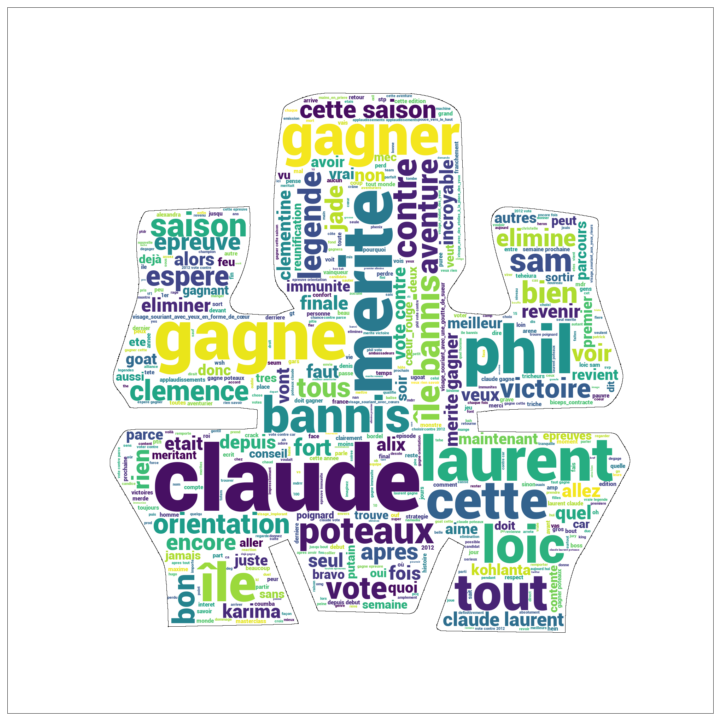

In [17]:
wc_ugo, words_count_ugo = plot_wordcloud_cv('Ugo', 14, stop_words_fr)

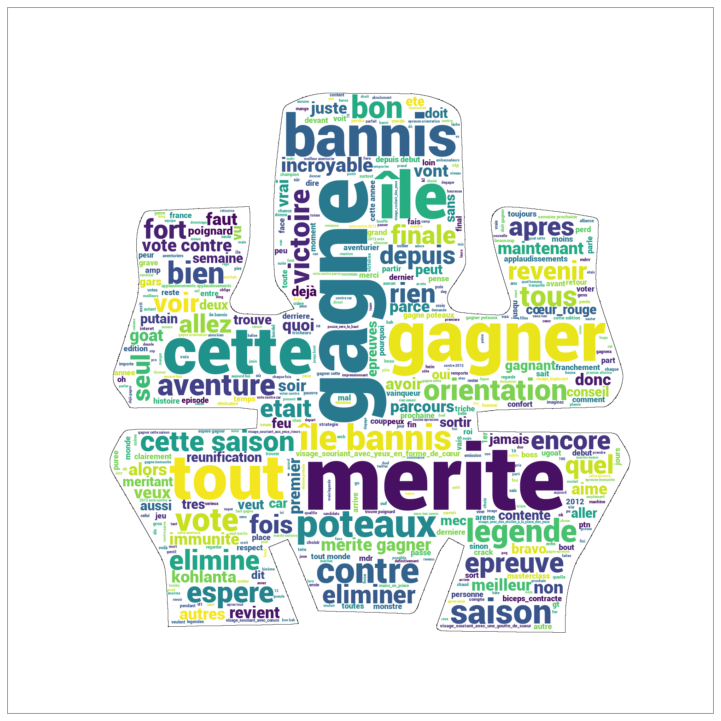

In [16]:
wc_ugo2, words_count_ugo2 = plot_wordcloud_cv('Ugo', 14, stop_words_no_name)

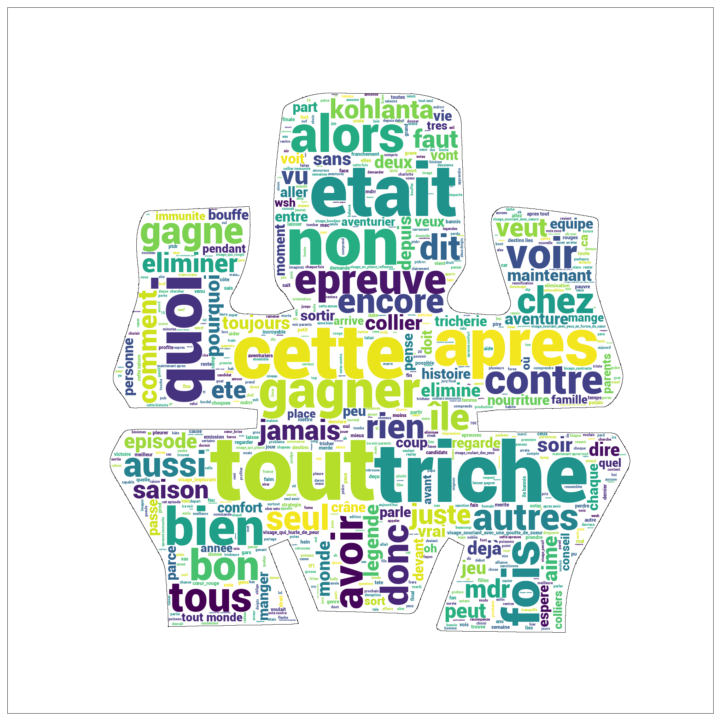

In [21]:
wc_tehe, words_count_tehe = plot_wordcloud_cv('Teheuira', 14, stop_words_no_name)

### Info complète sur candidat

In [58]:
def info_candidat(nom_candidat, until_em, stopwords):
    '''
    Retourne différentes infos sur un candidat:
    1. Son wordcloud associé
    2. Les 3 tweets le concernant les plus populaires
    3. Les 5 mots les plus utilisés quand on parle de lui
    4. Répartition des tweets dans le temps
    5. Nombre de tweets / Nombre de likes / Nombre de mentions
    '''
    
    df = all_infos(nom_candidat, until_em)
    
    wc, words_count = plot_wordcloud_cv(nom_candidat, 14, stopwords)
    
    print('Mots les plus utilisés')
    display(words_count.head(5))
    
    print('Top 3 des tweets les plus retweetés')
    display(df.sort_values(by='retweetCount', ascending=False).head(3))
    
    
    

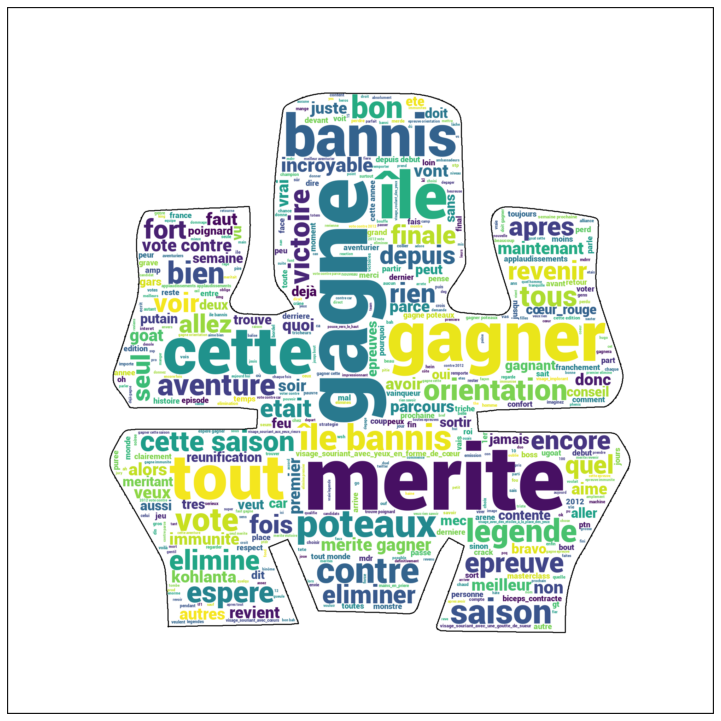

Mots les plus utilisés


merite    1855
gagne     1829
gagner    1487
cette     1290
île       1231
dtype: int64

Top 3 des tweets les plus retweetés


,Unnamed: 0,id,date,content,replyCount,retweetCount,likeCount,quoteCount,sourceLabel,hashtags,user_name,mentioned_users,isReply,isQuote,urlImg
4885,21356,1468321133049135111,2021-12-07 21:46:52+01:00,ugo depuis l’episode 1 koh lanta,23,2049,10311,21,Twitter for iPhone,['KohLanta'],imlauranus,NaN,False,False,https://pbs.twimg.com/media/FGCGSXcX0AICBuM?format=jpg&name=large
4511,20195,1468323897963593738,2021-12-07 21:57:52+01:00,le seul gars de la saison qui ait pas triche s’appelle ugo latriche ça me termine koh lanta koh lanta,28,1717,10250,47,Twitter for iPhone,"['kohlanta', 'KohLantaLaLegende']",MickaelAnge11,NaN,False,False,https://pbs.twimg.com/media/FGCIzXcXwBQJhPY?format=jpg&name=large
347,14442,1430284989313294336,2021-08-24 23:44:49+02:00,philippe vote contre ugo car il a vote contre lui en 2012 ???? ya pas a etre rancunier comme ça je suis outre koh lanta,34,1316,9688,83,Twitter for Android,['KohLanta'],KohLanta_OOC,NaN,False,False,NaN


In [75]:
info_candidat('Ugo', 14, stop_words_no_name)

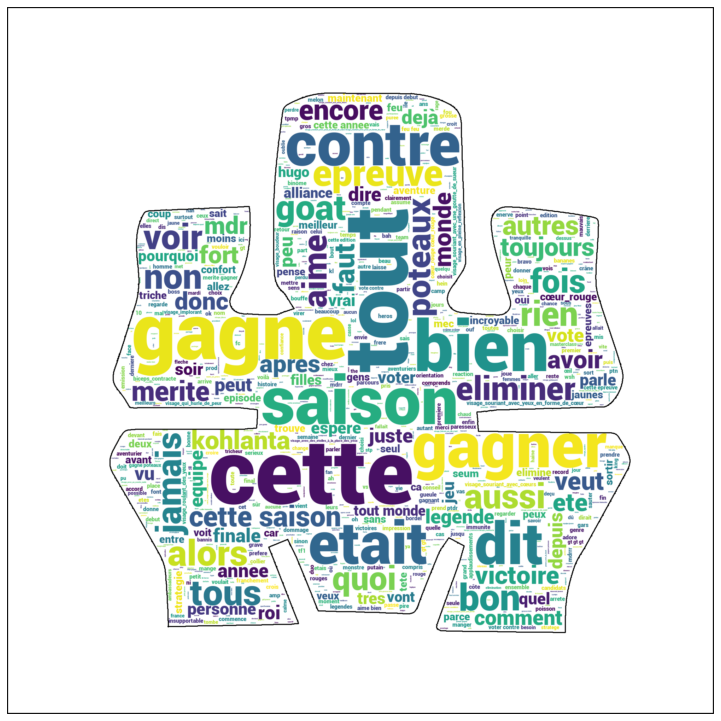

Mots les plus utilisés


cette     2506
tout      2494
gagne     2072
bien      1641
saison    1476
dtype: int64

Top 3 des tweets les plus retweetés


,Unnamed: 0,id,date,content,replyCount,retweetCount,likeCount,quoteCount,sourceLabel,hashtags,user_name,mentioned_users,isReply,isQuote,urlImg
3213,70598,1430255910287560706,2021-08-24 21:49:16+02:00,tf1 ils ont decide d'organiser 3 koh lanta par an jusqu'à ce que claude en gagne enfin un on dirait messi avec la copa america,42,5456,39930,109,Twitter Web App,NaN,TPedrajas,NaN,False,False,NaN
382,14566,1448021034192412672,2021-10-12 22:21:32+02:00,claude teheiura et laurent quand ils vont se retrouver à la reunif koh lanta,114,4334,19861,350,Twitter Web App,['KohLanta'],GatienRaurii,NaN,False,False,NaN
2287,23896,1437862855710285824,2021-09-14 21:36:33+02:00,"coumba : ""je suis pret à voter claude"" toute la france : koh lanta",29,1731,11250,31,Twitter Web App,['KohLanta'],Tilah,NaN,False,False,https://pbs.twimg.com/media/E_RQlVtWEAwnIl6?format=jpg&name=large


In [76]:
info_candidat('Claude', 14, stop_words_no_name)

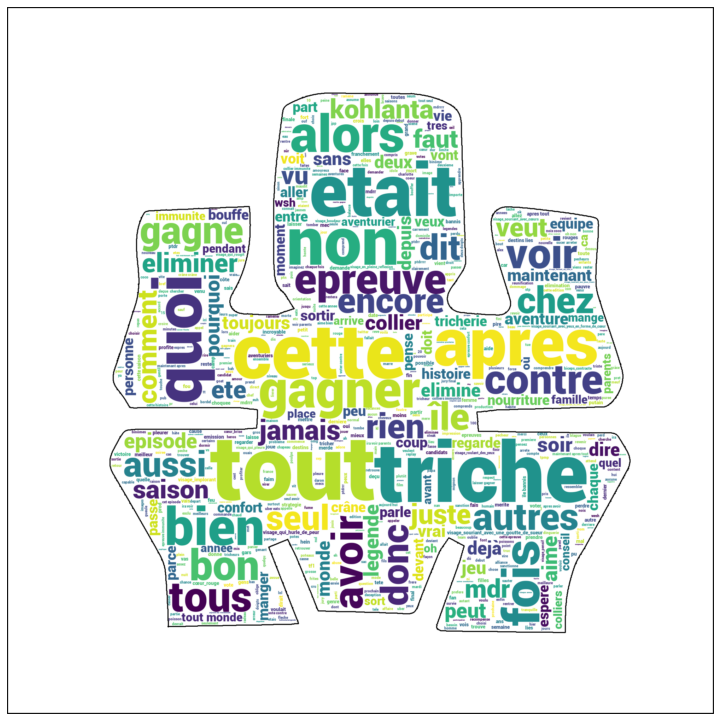

Mots les plus utilisés


tout      1646
triche    1380
cette     1157
etait     1055
non        885
dtype: int64

Top 3 des tweets les plus retweetés


,Unnamed: 0,id,date,content,replyCount,retweetCount,likeCount,quoteCount,sourceLabel,hashtags,user_name,mentioned_users,isReply,isQuote,urlImg
2785,9420,1458196176558301187,2021-11-09 23:13:55+01:00,« on a une commande au nom de teheiura » teheiura koh lanta,122,10981,62119,264,Twitter for iPhone,"['Teheiura', 'KohLanta']",RobinLassalle,NaN,False,False,https://pbs.twimg.com/media/FDyNsYUWEAEX7QL?format=jpg&name=large
646,13886,1453100036024324097,2021-10-26 22:43:40+02:00,"""ok papa cool ta vie mais j'vais raccrocher là, je suis avec teheiura"" koh lanta",41,4631,32379,68,Twitter Web App,['KohLanta'],lzedr_,NaN,False,False,https://pbs.twimg.com/media/FCpypidWUAIh0pT?format=png&name=large
57,14566,1448021034192412672,2021-10-12 22:21:32+02:00,claude teheiura et laurent quand ils vont se retrouver à la reunif koh lanta,114,4334,19861,350,Twitter Web App,['KohLanta'],GatienRaurii,NaN,False,False,NaN


In [77]:
info_candidat('Teheuira', 14, stop_words_no_name)

In [14]:
tmp = all_infos('Ugo', 14)
tmp.date = pd.to_datetime(tmp.date, utc=True)

tmp.date

0      2021-08-23 17:32:50+00:00
1      2021-08-23 16:33:14+00:00
2      2021-08-23 15:43:58+00:00
3      2021-08-23 15:19:49+00:00
4      2021-08-23 14:44:26+00:00
                  ...           
7208   2021-12-07 20:08:01+00:00
7209   2021-12-07 20:07:34+00:00
7210   2021-12-07 20:06:50+00:00
7211   2021-12-07 20:06:50+00:00
7212   2021-12-07 20:06:30+00:00
Name: date, Length: 20442, dtype: datetime64[ns, UTC]

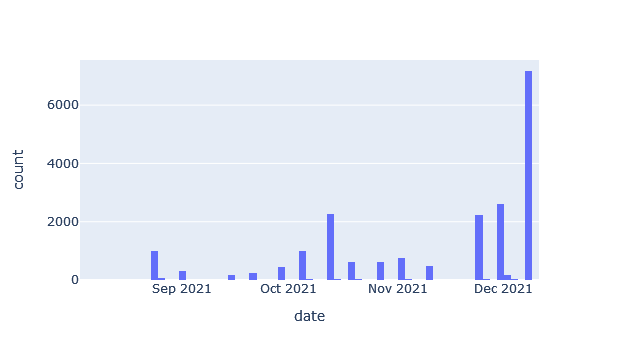

In [15]:
fig = px.histogram(tmp, x="date")
fig.show()

### Calcul du score de popularité en fonction des mentions et des réactions

In [59]:
def clean_data(df):
    
    to_return = df.drop_duplicates()
    return to_return

def simple_fame(df, nom_candidats):    
    
    data = {
        'nb_tweets':df.shape[0],
        'nb_likes':df.likeCount.sum(),
        'nb_retweets':df.retweetCount.sum(),
#         'nb_not_reply':df.isReply.sum(),
#         'nb_image':df.urlImg.count()
    }
    
    return pd.DataFrame(data, index=nom_candidats)

def gen_simple_fame(nom_candidats=nom_candidats, path=''):
    to_return = pd.DataFrame()    
    
    for nom in nom_candidats:
        df = pd.read_csv(path + nom.lower() + '.csv')
        to_concat = simple_fame(clean_data(df), [nom])
        
        to_return = pd.concat([to_return, to_concat])
    return to_return

def gen_score_simple_fame(results, name_col):
    to_return = {}
    
    for nom in results.index.tolist(): # Les keys sont les noms des candidats
        to_return[nom] = 0 # J'initialise toutes les keys de mon dict à 0
    
    cols = results.columns # Les cols correspondent à mes critères de popularité (nb_like, nb_retweets...)
    for col in cols:
        to_check = results[col].sort_values()
        for ind, nom in enumerate(to_check.index): # Je regarde chaque candidat un à un
            to_return[nom] += to_check.loc[nom] # La valeur du critère 
            
    return pd.DataFrame(to_return.values(), index=to_return.keys()).rename(columns={0:name_col}).sort_values(by=name_col, ascending=False)

In [60]:
all_scores = pd.DataFrame()

for num in range(0,15):
    path_to_load = f'./data_jugement/em{num}/'
    name_col = f'score_em{num}'
    results_emission = gen_simple_fame(nom_candidats, path_to_load)
    score_emission = gen_score_simple_fame(results_emission, name_col)
    all_scores = pd.concat([all_scores, score_emission], axis=1)

In [61]:
all_scores

,score_em0,score_em1,score_em2,score_em3,score_em4,score_em5,score_em6,score_em7,score_em8,score_em9,score_em10,score_em11,score_em12,score_em13,score_em14
Denis,23124,61930,18919,19891,41060,17501,13025,48554,15201,12458,18471,77505,5350,11583,17411
Sam,15716,388541,41665,50412,22473,50723,57532,8938,24646,180106,149463,77560,11873,66089,4642
Claude,13293,131489,39624,70306,103331,45710,50287,44347,31225,106692,91258,52003,96008,68695,37601
Teheuira,9426,222338,67710,55397,29467,62251,63012,39977,8524,181539,115468,529675,21561,7219,7806
Clementine,8179,127159,32452,5180,58275,16417,11364,96848,2781,1881,302,49,74,4,3393
Freddy,6256,180918,8513,3699,230,311,660,148,313,224,2581,6150,1710,109,184
Karima,4532,151502,51438,30494,25764,475,58,78,1155,30,158,78,26,17,8
Namadia,2991,31148,31782,13003,22970,43942,26266,21208,84096,26018,1254,6938,371,127,357
Phil,2690,89496,31675,9716,1265,27207,12140,27136,10554,31133,76096,12955,5600,68689,96220
Alexandra,1389,33297,142999,49937,129917,17401,22419,2568,16572,73665,34281,14736,3596,375,697


<AxesSubplot:ylabel='Ugo'>

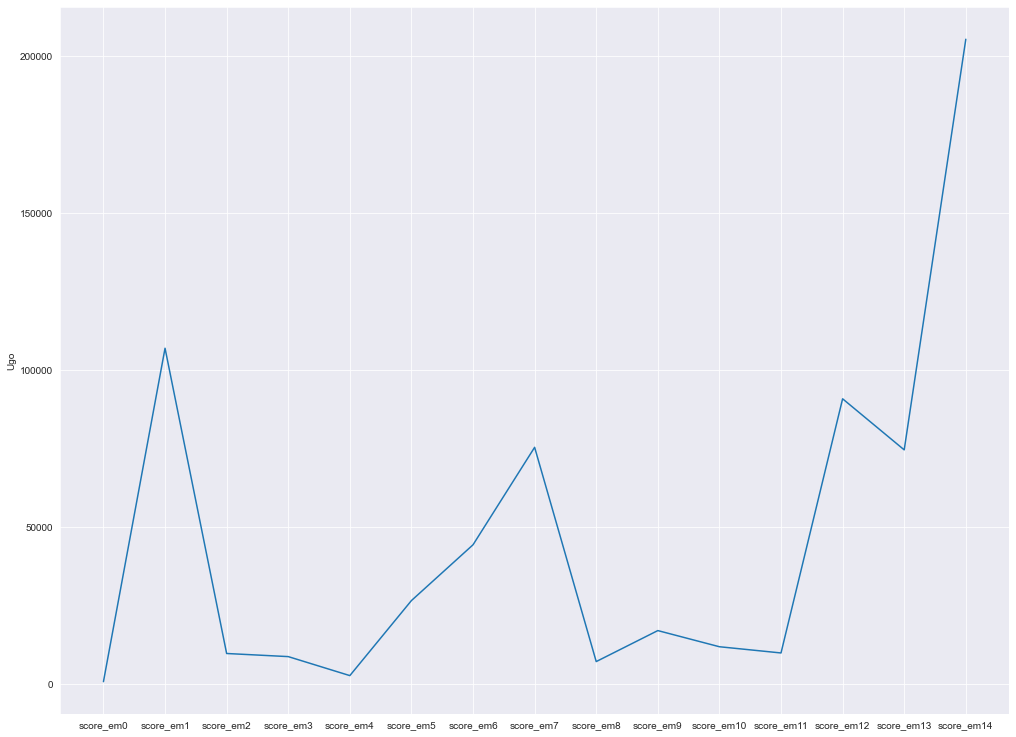

In [78]:
sns.lineplot(x=all_scores.columns, y=all_scores.loc['Ugo'])


#### Normalisation

En normalisant, je peux savoir qui a fait le plus parlé de lui pour une émission donnée

In [62]:
norm_all_scores = pd.DataFrame()

for col in all_scores.columns:
    to_scale = all_scores[col] # Colonne à normaliser
    norm_all_scores = pd.concat([norm_all_scores, (to_scale - to_scale.min() )/(to_scale.max() - to_scale.min())], axis=1)

In [63]:
norm_all_scores[(norm_all_scores == 1)]

,score_em0,score_em1,score_em2,score_em3,score_em4,score_em5,score_em6,score_em7,score_em8,score_em9,score_em10,score_em11,score_em12,score_em13,score_em14
Denis,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sam,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Claude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Teheuira,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
Clementine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Freddy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Karima,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Namadia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Phil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alexandra,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
norm_all_scores.loc['Teheuira']

score_em0     0.405624
score_em1     0.571263
score_em2     0.466988
score_em3     0.635541
score_em4     0.222601
score_em5     0.864453
score_em6     0.536871
score_em7     0.412581
score_em8     0.034740
score_em9     1.000000
score_em10    0.772536
score_em11    1.000000
score_em12    0.216128
score_em13    0.096775
score_em14    0.038015
Name: Teheuira, dtype: float64

In [73]:
norm_all_scores.loc['Ugo']

score_em0     0.029463
score_em1     0.273549
score_em2     0.056530
score_em3     0.094132
score_em4     0.020170
score_em5     0.368982
score_em6     0.377767
score_em7     0.778247
score_em8     0.029169
score_em9     0.093737
score_em10    0.079423
score_em11    0.018670
score_em12    0.910537
score_em13    1.000000
score_em14    1.000000
Name: Ugo, dtype: float64

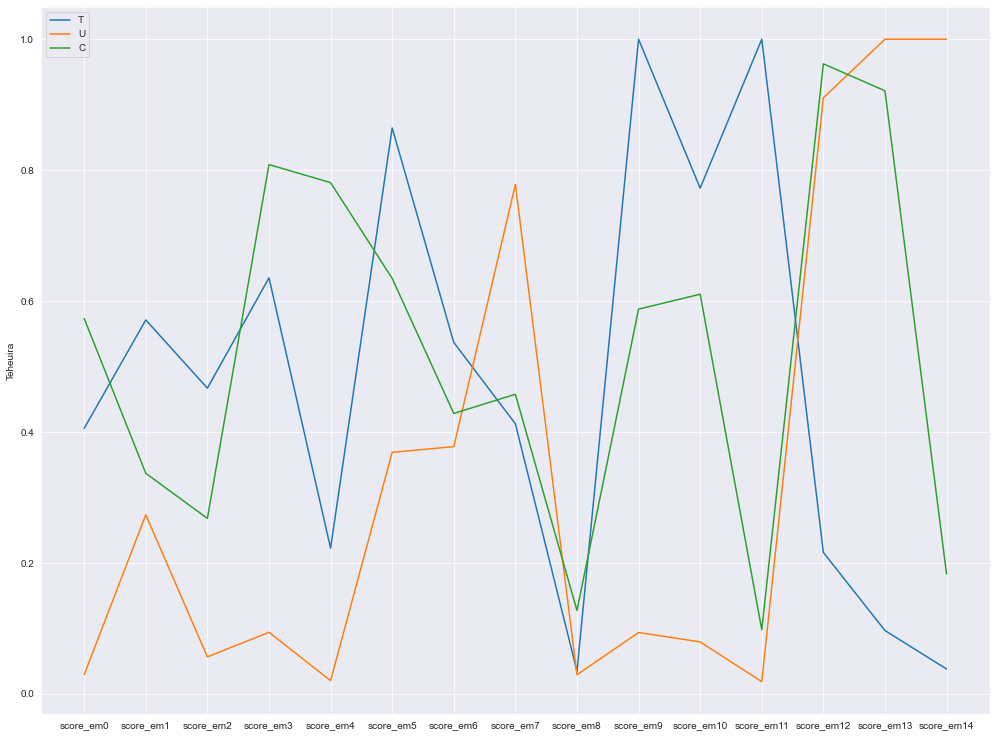

In [70]:
sns.lineplot(x=norm_all_scores.columns, y=norm_all_scores.loc['Teheuira'])
sns.lineplot(x=norm_all_scores.columns, y=norm_all_scores.loc['Ugo'])
sns.lineplot(x=norm_all_scores.columns, y=norm_all_scores.loc['Claude'])
plt.legend(['T', 'U', 'C'])

# Questions

## Quel candidat a le plus souvent fait le + parler de lui ?

In [367]:
(norm_all_scores == 1).sum(axis=1).sort_values(ascending=False)

Coumba        5
Ugo           2
Teheuira      2
Sam           2
Denis         1
Alexandra     1
Loic          1
Clementine    1
Namadia       0
Phil          0
Karima        0
Clemence      0
Freddy        0
Cindy         0
Laurent       0
Maxime        0
Claude        0
Patrick       0
Candice       0
Alix          0
Christelle    0
Jade          0
dtype: int64

## Quel candidat a provoqué globalement le plus de réactions ?

In [368]:
all_scores.sum(axis=1).sort_values(ascending=False)

Teheuira      1421370
Sam           1150379
Coumba        1078105
Claude         981869
Ugo            691833
Alexandra      543849
Loic           526624
Phil           502572
Laurent        469140
Denis          401983
Clementine     364358
Clemence       328245
Alix           315515
Namadia        312471
Karima         265813
Jade           245632
Freddy         212006
Cindy          130993
Christelle      99485
Patrick         87196
Candice         74998
Maxime          52149
dtype: int64

---

# Pour mieux comprendre

## NER

---

In [90]:
%%time
tweet_sample = df_em2
tweet_sample.content = tweet_sample.content.apply(nlp_pipeline)

# Par batch de 512, récupère l'ensemble des entités "Personnes" trouvées dans le contenu des tweets
persons = []
start = 0
for stop in range(0, tweet_sample.shape[0], 512):
    output = nlp(' '.join(tweet_sample.iloc[start:stop].content.values)) # Concatène 512 tweets en un seul string
    start = stop
    for entity in output:
        if entity['entity_group'] == 'PER':
            persons.append(entity['word']) # Ajoute l'entité reconnue à notre liste

Wall time: 2min 30s


In [162]:
tmp = persons

tmp = list(map(lambda x: x.split(), tmp)) # On éclate en un unique mots les entités contenant plusieurs mots (Ex: 'Claude le meilleur')
clean = []
for nom in tmp:
    if type(nom)==list:
        clean += nom
    else:
        clean.append(nom)
clean = [nom for nom in clean if (len(nom) > 2 and len(nom) < 13)]
clean = np.unique(clean)
clean

array(['ade', 'ahmad', 'alex', 'alexandra', 'alexia', 'alix', 'amed',
       'ana', 'arnaud', 'aubrey', 'aure', 'auville', 'ayunemin',
       'azyllor', 'baquet', 'beka', 'benjamin', 'benzema', 'bertrand',
       'biceps', 'blaze', 'bou', 'brad', 'brognard', 'brogniart',
       'candice', 'canner', 'canteloup', 'cauet', 'ceo', 'chtijug',
       'cindy', 'cla', 'claud', 'claude', 'clem', 'clemence',
       'clementine', 'couba', 'coumba', 'covid', 'cumba', 'curry',
       'davibasteni', 'declo', 'denis', 'deschamps', 'deujna', 'dheliat',
       'digne', 'dimabah', 'domingo', 'drizzle152', 'dubois',
       'dupontaignan', 'duriani', 'ele', 'els', 'eric', 'etchebest',
       'evelyne', 'feu', 'fpoisson78', 'freddy', 'fredzoul', 'girardot',
       'grandlarge', 'griezmann', 'gwen', 'hadja', 'hurler', 'hutao',
       'imbecile', 'ine', 'inefabienco', 'jade', 'javier', 'jong',
       'josepaumard', 'jules', 'julienngh', 'kamal', 'kante', 'kar',
       'karim', 'karima', 'khey', 'kimpembe', '

In [225]:
surnoms_trouvés['Freddy'] = np.append(np.array('1 2'),'oik')
surnoms_trouvés

{'Freddy': array(['1 2', 'oik'], dtype='<U3'),
 'Teheuira': array(['teheiura', 'teheuira', 'tehura', 'theuira'], dtype='<U12'),
 'Patrick': array(['patrick', 'patrik'], dtype='<U12'),
 'Alexandra': array(['alexandra'], dtype='<U12'),
 'Cindy': array(['cindy'], dtype='<U12'),
 'Claude': array(['claud', 'claude'], dtype='<U12'),
 'Karima': array(['karim', 'karima'], dtype='<U12'),
 'Jade': array(['ade', 'jade'], dtype='<U12'),
 'Maxime': array(['maxime'], dtype='<U12'),
 'Laurent': array(['laurent'], dtype='<U12'),
 'Candice': array(['candice'], dtype='<U12'),
 'Sam': array(['sam'], dtype='<U12'),
 'Clementine': array(['clementine'], dtype='<U12'),
 'Ugo': array(['ugo'], dtype='<U12'),
 'Namadia': array(['namadia'], dtype='<U12'),
 'Christelle': array([], dtype='<U12'),
 'Coumba': array(['couba', 'coumba', 'cumba', 'umba'], dtype='<U12'),
 'Loic': array(['loic', 'loïc'], dtype='<U12'),
 'Clemence': array(['clemence'], dtype='<U12'),
 'Phil': array(['phil'], dtype='<U12'),
 'Alix': array(

In [228]:
surnoms_trouvés = {}

for nom in nom_candidats:
    res = []
    distance_max = round(len(nom)*0.25) # La distance de levenshtein maximum acceptée pour considérer cela comme une faute de frappe/Une autre appellation du candidat
    for entity in clean: # Calcul de la distance pour chaque entité trouvée
        res.append(distance(entity, nom.lower()))
    res = pd.Series(res)
    surnoms_trouvés[nom] = np.unique(np.append(clean[res[res <= distance_max].index], nom.lower()))
    
surnoms_trouvés

{'Freddy': array(['freddy'], dtype='<U12'),
 'Teheuira': array(['teheiura', 'teheuira', 'tehura', 'theuira'], dtype='<U12'),
 'Patrick': array(['patrick', 'patrik'], dtype='<U12'),
 'Alexandra': array(['alexandra'], dtype='<U12'),
 'Cindy': array(['cindy'], dtype='<U12'),
 'Claude': array(['claud', 'claude'], dtype='<U12'),
 'Karima': array(['karim', 'karima'], dtype='<U12'),
 'Jade': array(['ade', 'jade'], dtype='<U12'),
 'Maxime': array(['maxime'], dtype='<U12'),
 'Laurent': array(['laurent'], dtype='<U12'),
 'Candice': array(['candice'], dtype='<U12'),
 'Sam': array(['sam'], dtype='<U12'),
 'Clementine': array(['clementine'], dtype='<U12'),
 'Ugo': array(['ugo'], dtype='<U12'),
 'Namadia': array(['namadia'], dtype='<U12'),
 'Christelle': array(['christelle'], dtype='<U12'),
 'Coumba': array(['couba', 'coumba', 'cumba', 'umba'], dtype='<U12'),
 'Loic': array(['loic', 'loïc'], dtype='<U12'),
 'Clemence': array(['clemence'], dtype='<U12'),
 'Phil': array(['phil'], dtype='<U12'),
 'Alix

---

## On sait jamais

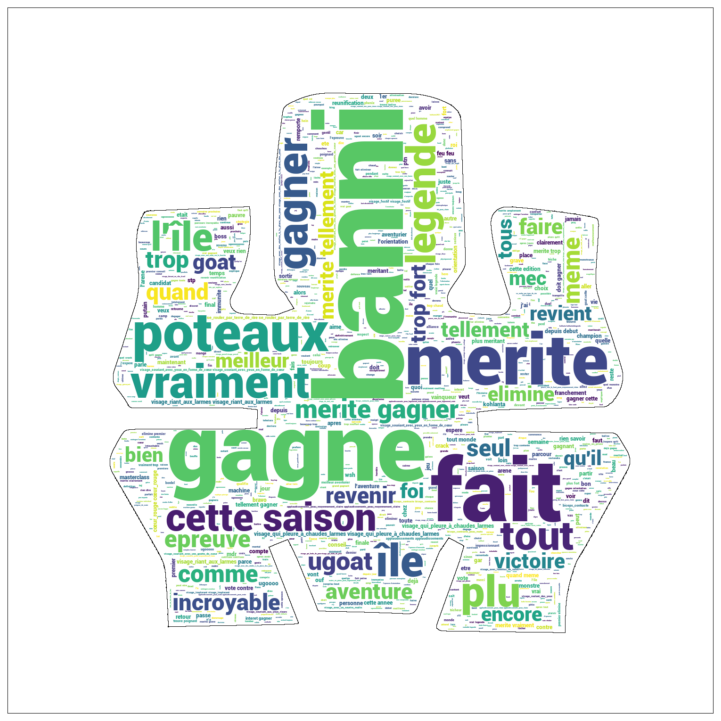

In [245]:
w = all_infos('Ugo')
all_text = ' '.join(w.content.values.tolist())

# mask = np.array(Image.open('./wordcloud/Totem.png'))
img = cv2.imread('./wordcloud/Totem2.png')
res = cv2.resize(img, dsize=(1500, 1500), interpolation=cv2.INTER_CUBIC)

stop_words_fr = set(stopwords.words('french'))
stop_words_fr.update(['koh', 'lanta', 'va', 'c\'est'])
stop_words_fr.update(list(map(lambda x: x.lower(), nom_candidats)))

wc = WordCloud(stopwords=stop_words_fr, font_path='./wordcloud/Roboto-Black.ttf',
               background_color="white", mask=res, contour_width=1,
               max_words=2000, max_font_size=256, min_word_length=3, width=mask.shape[1],
               height=mask.shape[0],
               random_state=42)
wc.generate(all_text)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [224]:
stop_words_fr = set(stopwords.words('french'))
stop_words_fr.update(['koh', 'lanta'])
stop_words_fr.update(list(map(lambda x: x.lower(), nom_candidats)))



(6566, 15)


merite                                787
gagner                                672
va                                    534
île                                   519
gagne                                 467
bannis                                458
trop                                  454
cette                                 412
vraiment                              392
plus                                  378
fait                                  377
île bannis                            374
ça                                    334
poteaux                               333
tout                                  331
tellement                             283
saison                                278
visage_qui_pleure_à_chaudes_larmes    263
legende                               257
fort                                  238
dtype: int64